# Example Jupyter notebook utilizing PmagPy for analysis of paleomagnetic data

This notebook focuses on the analysis of two contributions to the MagIC database the developed data from the Osler Volcanic Group.

> Halls, H. (1974), A paleomagnetic reversal in the Osler Volcanic Group, northern Lake Superior, Can. J. Earth Sci., 11, 1200–1207, doi:10.1139/e74–113. Link to MagIC contribution:

> Swanson-Hysell, N. L., A. A. Vaughan, M. R. Mustain, and K. E. Asp (2014), Confirmation of progressive plate motion during the Midcontinent Rift’s early magmatic stage from the Osler Volcanic Group, Ontario, Canada, Geochem. Geophys. Geosyst., 15, 2039–2047, doi:10.1002/2013GC005180. Link to MagIC contribution:

The following is accomplished in this notebook:

* The data are unpacked from MagIC database contributions.
* The directions and VGPs from each study are visualized.
* Fisher means are calcuated on directions and VGPs.
* A bootstrap fold test is conducted on the data.

## Import necessary function libraries for the data analysis

The code block below imports necessary libraries from PmagPy that define functions that will be used in the data analysis. Using 'sys.path.insert' allows you to point to the directory where you keep PmagPy in order to import it. **You will need to change the path to match where the PmagPy folder is on your computer.**

The numpy, scipy, matplotlib and pandas libraries are standard libraries for scientific python (see http://www.scipy.org) that come with the Enthought or Anaconda distributions. In the code block below we import `pandas` and give it the commonly used nickname `pd`. We import `matplotlib.pyplot` giving it the nickname `plt`. The `%matplotlib inline` command is necessary to allow the plots to be generated within the notebook instead of in an external window.

In [1]:
import sys
#change to match where the PmagPy folder is on your computer
sys.path.insert(0, '/Users/Laurentia/PmagPy')
import pmag
import ipmag
import ipmagplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Background on the Osler Volcanic Group

The Osler Volcanic Group is a sequence of Midcontinent Rift lava flows exposed on Black Bay Peninsula and the Lake Superior Archipelago in northern Lake Superior. *Halls (1974)* conducted the first paleomagnetic study of these flows and determined that they were of dominantly reversed polarity with a paleomagnetic reversal very near to the top of the exposed stratigraphy. This reversal is associated with the deposition of a conglomerate unit and an angular unconformity. The data presented in *Halls (1974)* from the reversed polarity lavas were from flows high in the  succession in close stratigraphic proximity to a sequence of felsic flows at Agate Point---one of which was dated by *Davis and Green (1997)* with a resulting $^{207}$Pb/$^{206}$Pb date on zircon of 1105.3±2.1 Ma. *Swanson-Hysell et al. (2014b)* conducted a paleomagnetic study that spanned more of the Osler Group flows from their base up to the upper portions of the exposed reversed polarity flows. The analysis of these data determined that there was a significant change in direction between the data from flows in the lower third of the reversed polarity stratigraphy and those in the upper third stratigraphy. This change was interpretted to be due to progression along the APW path associated with equatorward motion of Laurentia.

## Unpack files downloaded from the MagIC database

Data within the MagIC database can be downloaded as a single .txt file. This file can be split into its constituent Earthref and pmag tables either within the QuickMagic GUI, using a command line PmagPy program or using a function such as ```ipmag.download_magic``` within the notebook as is done here. The code block below uses this function by giving the file name, specifying where it is and telling it where to unpack the Halls data set into these tables. Once these tables are unpacked we can use them for subsequent data analysis.

In [2]:
ipmag.download_magic('zmab0089123tmp02.txt',
                     dir_path='./Data/Halls1974',
                     input_dir_path='./Data/Halls1974',
                     overwrite=True,print_progress=False)

2  records written to file  ./Data/Halls1974/er_locations.txt
30  records written to file  ./Data/Halls1974/er_sites.txt
5  records written to file  ./Data/Halls1974/er_citations.txt
60  records written to file  ./Data/Halls1974/pmag_sites.txt
32  records written to file  ./Data/Halls1974/pmag_results.txt
9  records written to file  ./Data/Halls1974/magic_methods.txt
directory  ./Data/Halls1974/Location_1  already exists - overwriting everything: True
1  records written to file  ./Data/Halls1974/Location_1/er_locations.txt
25  records written to file  ./Data/Halls1974/Location_1/er_sites.txt
50  records written to file  ./Data/Halls1974/Location_1/pmag_sites.txt
26  records written to file  ./Data/Halls1974/Location_1/pmag_results.txt
directory  ./Data/Halls1974/Location_2  already exists - overwriting everything: True
1  records written to file  ./Data/Halls1974/Location_2/er_locations.txt
5  records written to file  ./Data/Halls1974/Location_2/er_sites.txt
10  records written to file

True

## Putting the unpacked data into local dataframes

With the results unpacked from MagIC, the data can now be analyzed within the notebook. The data from the pmag_sites table can be imported in order to look at the directions from each site. A nice way to deal with data within Python is using the dataframe structure of the pandas package. The code block below uses the `pd.read_csv` function to create a dataframe from the pmag_sites.txt file. The `.head()` function allows us to inspect the first row of the resulting dataframe.

In [3]:
Halls1974_sites = pd.read_csv('./Data/Halls1974/pmag_sites.txt',sep='\t',skiprows=1)
Halls1974_sites.head(1)

,er_citation_names,er_location_name,er_site_name,magic_method_codes,site_dec,site_inc,site_k,site_n,site_polarity,site_tilt_correction
0,This study,"Osler Volcanics, Nipigon Strait, Upper Normal",1,DE-K:FS-FD:FS-H:LP-DC2:SO-SM,289.8,43.6,517,5,n,100


### Filtering by polarity and tilt-correction

Let's focus our analysis on the reversed polarity sites that are below the angular unconformity. A nice thing about dataframes is that there is built-in functionality to filter them based on column valus. The code block below creates a new dataframe of sites that have the site_polarity value of 'r' in the pmag_sites table. It then creates one dataframe for tilt-corrected sites (value of 100 in site_tilt_correction) and sites that have not been tilt-corrected (value of 0 in site_tilt_correction).

In [4]:
Halls1974_sites_r = Halls1974_sites.ix[Halls1974_sites.site_polarity=='r']
Halls1974_sites_r_tc = Halls1974_sites_r.ix[Halls1974_sites_r.site_tilt_correction==100]
Halls1974_sites_r_tc.reset_index(inplace=True)
Halls1974_sites_r_is = Halls1974_sites_r.ix[Halls1974_sites_r.site_tilt_correction==0]
Halls1974_sites_r_is.reset_index(inplace=True)

## Data analysis and visualization

Fisher means for the data can be calculated the function `ipmag.fisher_mean`. This function takes in a list of declination values, a list of inclination values and returns a dictionary that gives the Fisher mean and associated statistics. This dictionary is printed out for the mean of the tilt-corrected data within the first code block. The second code block uses the `ipmag.print_direction_mean` to print out a formatted version of these same results.

In [5]:
Halls1974_r_is_mean = ipmag.fisher_mean(Halls1974_sites_r_is.site_dec.tolist(),
                                        Halls1974_sites_r_is.site_inc.tolist())
Halls1974_r_tc_mean = ipmag.fisher_mean(Halls1974_sites_r_tc.site_dec.tolist(),
                                        Halls1974_sites_r_tc.site_inc.tolist())
print Halls1974_r_tc_mean

{'csd': 12.780983354077163, 'k': 40.164419949836713, 'n': 25, 'r': 24.402456203028084, 'alpha95': 4.6244793676899487, 'dec': 114.96744501761694, 'inc': -57.572956213862817}


In [6]:
print 'The mean for the tilt-corrected Halls (1974) Osler directions is:'
ipmag.print_direction_mean(Halls1974_r_tc_mean)

The mean for the tilt-corrected Halls (1974) Osler directions is:
Dec: 115.0  Inc: -57.6
Number of directions in mean (n): 25
Angular radius of 95% confidence (a_95): 4.6
Precision parameter (k) estimate: 40.2


### Plotting the results

The data can be visualized using PmagPy plotting functions. The first code block below creates a figure with an equal area stereonet and then uses the `ipmag.plot_di` function to plot the data both in tilt-corrected and *in situ* coordinates. The second code block makes a similar figure that plots of Fisher means calculated above. These figure can then be saved out of the notebook using the `plt.savefig()` function.

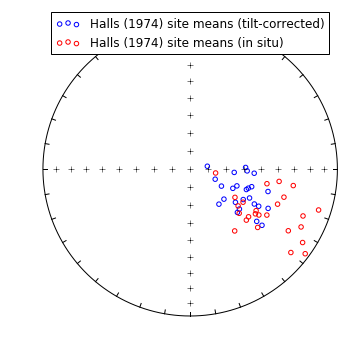

In [7]:
plt.figure(num=1,figsize=(5,5))
ipmag.plot_net(fignum=1)
ipmag.plot_di(Halls1974_sites_r_tc.site_dec.tolist(),
              Halls1974_sites_r_tc.site_inc.tolist(),'b',
             label='Halls (1974) site means (tilt-corrected)')
ipmag.plot_di(Halls1974_sites_r_is.site_dec.tolist(),
              Halls1974_sites_r_is.site_inc.tolist(),'r',
              label='Halls (1974) site means (in situ)')
plt.legend(loc=9)
plt.savefig('Notebook_Output/Halls_1974_sites.svg')

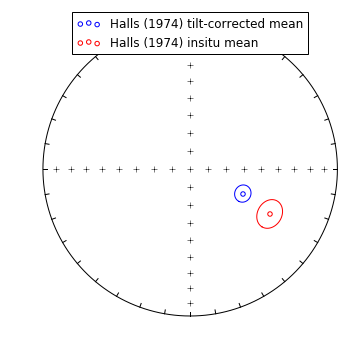

In [8]:
plt.figure(num=1,figsize=(5,5))
ipmag.plot_net(fignum=1)
ipmag.plot_di_mean(Halls1974_r_tc_mean['dec'],
                   Halls1974_r_tc_mean['inc'],
                   Halls1974_r_tc_mean['alpha95'],'b',
                   label='Halls (1974) tilt-corrected mean')
ipmag.plot_di_mean(Halls1974_r_is_mean['dec'],
                   Halls1974_r_is_mean['inc'],
                   Halls1974_r_is_mean['alpha95'],'r',
                   label='Halls (1974) insitu mean')
plt.legend(loc=9)
plt.savefig('Notebook_Output/Halls_1974_means.svg')

The means that have been calculated are now dictionaries that can be made into a new dataframe to present the results. A table like this can be exported into a variety of formats for inclusion in a publication. 

In [9]:
Halls1974_r_is_mean = ipmag.fisher_mean(Halls1974_sites_r_is.site_dec.tolist(),
                                        Halls1974_sites_r_is.site_inc.tolist())
Halls1974_r_tc_mean = ipmag.fisher_mean(Halls1974_sites_r_tc.site_dec.tolist(),
                                        Halls1974_sites_r_tc.site_inc.tolist())
means = pd.DataFrame([Halls1974_r_is_mean,Halls1974_r_tc_mean],
                     index=['Halls 1974 Osler R (insitu)','Halls 1974 Osler R (tilt-corrected)'])
means

,alpha95,csd,dec,inc,k,n,r
Halls 1974 Osler R (insitu),7.429483,20.147915,119.491601,-37.834483,16.162548,25,23.515086
Halls 1974 Osler R (tilt-corrected),4.624479,12.780983,114.967445,-57.572956,40.164420,25,24.402456


## Unpacking and visualizing Swanson-Hysell et al. (2014) 

The Swanson-Hysell et al. (2014) data can be unpacked from the MagIC contribution. The pmag_results table has the data and VPGs that can be brought into a dataframe.

In [10]:
%%capture
ipmag.download_magic('magic_contribution_10231.txt',
                     dir_path='./Data/Swanson-Hysell2014/',
                     input_dir_path='./Data/Swanson-Hysell2014/',
                     overwrite=True,print_progress=False);

True

In [11]:
SH2014_sites = pd.read_csv('./Data/Swanson-Hysell2014/pmag_results.txt',sep='\t',skiprows=1)
SH2014_sites.head(1)

,average_age,average_age_high,average_age_low,average_age_unit,average_alpha95,average_dec,average_height,average_inc,average_lat,average_lon,...,er_site_names,magic_method_codes,pmag_result_name,tilt_dec_corr,tilt_dec_uncorr,tilt_inc_corr,tilt_inc_uncorr,vgp_alpha95,vgp_lat,vgp_lon
0,1106,1110,1103,Ma,2.7,79.7,11.8,-70.5,48.8122,-87.662,...,SI1(11.8 to 26.4),DE-FM:LP-DC4:LP-DIR-AF,SI1(11.8 to 26.4),79.7,120.3,-70.5,-77.1,NaN,33.1,229.6


Swanson-Hysell et al. (2014b) argued that data from the upper third of the Simpson Island stratigraphy should be compared with the reversed data from the Halls (1974) Nipigon Strait region study. The dataframe can be filtered using the average_height value from the pmag_results table.

In [12]:
SH2014_OslerR_upper = SH2014_sites.ix[SH2014_sites.average_height>2082]
SH2014_OslerR_upper.reset_index(inplace=True)

In [13]:
SH2014_OslerR_upper.head(1)

,index,average_age,average_age_high,average_age_low,average_age_unit,average_alpha95,average_dec,average_height,average_inc,average_lat,...,er_site_names,magic_method_codes,pmag_result_name,tilt_dec_corr,tilt_dec_uncorr,tilt_inc_corr,tilt_inc_uncorr,vgp_alpha95,vgp_lat,vgp_lon
0,50,1106,1110,1103,Ma,4.3,120.7,2089,-56.8,48.7499,...,SI4(106.0 to 121.4),DE-FM:LP-DC4:LP-DIR-AF,SI4(106.0 to 121.4),120.7,140,-56.8,-46.6,NaN,46.4,190.3


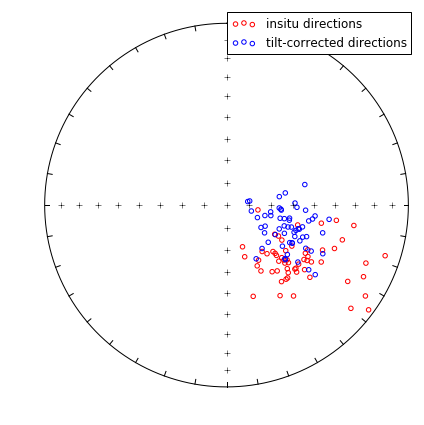

The Fisher mean of the insitu upper Osler R directions:
Dec: 128.3  Inc: -47.6
Number of directions in mean (n): 59
Angular radius of 95% confidence (a_95): 4.2
Precision parameter (k) estimate: 19.9

The Fisher mean of the tilt-corrected upper Osler R directions:
Dec: 110.9  Inc: -59.9
Number of directions in mean (n): 59
Angular radius of 95% confidence (a_95): 2.8
Precision parameter (k) estimate: 43.9

The k_2/k_1 ratio is:
2.20159915009


In [14]:
SH2014_upperR_dec_is = SH2014_OslerR_upper['tilt_dec_uncorr'].tolist()
SH2014_upperR_inc_is = SH2014_OslerR_upper['tilt_inc_uncorr'].tolist()
SH2014_upperR_dec_tc = SH2014_OslerR_upper['tilt_dec_corr'].tolist()
SH2014_upperR_inc_tc = SH2014_OslerR_upper['tilt_inc_corr'].tolist()

Halls1974_upperR_dec_is = Halls1974_sites_r_is['site_dec'].tolist()
Halls1974_upperR_inc_is = Halls1974_sites_r_is['site_inc'].tolist()
Halls1974_upperR_dec_tc = Halls1974_sites_r_tc['site_dec'].tolist()
Halls1974_upperR_inc_tc = Halls1974_sites_r_tc['site_inc'].tolist()

combined_upperR_dec_is = np.concatenate((SH2014_upperR_dec_is,
                                        Halls1974_upperR_dec_is), axis=0)
combined_upperR_inc_is = np.concatenate((SH2014_upperR_inc_is,
                                        Halls1974_upperR_inc_is), axis=0)

combined_upperR_dec_tc = np.concatenate((SH2014_upperR_dec_tc,
                                        Halls1974_upperR_dec_tc), axis=0)
combined_upperR_inc_tc = np.concatenate((SH2014_upperR_inc_tc,
                                        Halls1974_upperR_inc_tc), axis=0)

plt.figure(num=1,figsize=(6,6))
ipmag.plot_net(fignum=1)
ipmag.plot_di(combined_upperR_dec_is,
              combined_upperR_inc_is,'r', label='insitu directions')
ipmag.plot_di(combined_upperR_dec_tc,
              combined_upperR_inc_tc,'b', label='tilt-corrected directions')
plt.legend()
plt.show()

OslerUpper_is_mean = ipmag.fisher_mean(combined_upperR_dec_is,
                                       combined_upperR_inc_is)
print "The Fisher mean of the insitu upper Osler R directions:"
ipmag.print_direction_mean(OslerUpper_is_mean)
print ''
OslerUpper_tc_mean = ipmag.fisher_mean(combined_upperR_dec_tc,
                                      combined_upperR_inc_tc)
print "The Fisher mean of the tilt-corrected upper Osler R directions:"
ipmag.print_direction_mean(OslerUpper_tc_mean)
print ''
print 'The k_2/k_1 ratio is:'
print OslerUpper_tc_mean['k']/OslerUpper_is_mean['k']

In the above plot, the blue directions that have been corrected for tilting have a higher precision than the red values that are uncorrected for tilting. The ratio of the precision parameter from before and after tilt-correction (k$_2$/k$_1$) is 2.2 (see output of code above). Calculating this ratio provides a way to qualitatively assess whether there is improvement in the precision of the data such that the magnetization was likely acquired prior to tilting. This ratio was at the heart of the McElhinny (1964) fold test (in which this would constitute of a positive test). However, that test has been shown to not be meaningful as summarized by Enkin (2003):

> McElhinny [5] introduced a formulation (designated the KR test) which checks whether the concentration of site directions is signicantly better in stratigraphic than in geographic coordinates. Specically, it tests the null hypothesis that the dispersion of directions as measured by the Fisher concentration parameter, k, is the same in both coordinate systems. If the ratio of concentrations in stratigraphic and geographic coordinates, kS /kG , is signicantly greater than 1, then the null hypothesis is rejected and one interprets that the magnetization is pre-tilting. The KR test is easy to implement, so the test has been widely used in paleomagnetism. Nevertheless, McFadden and Jones [6] showed that the statistical inference is meaningless. While the ratio kS/kG is useful for qualitative analysis, it is incorrect to claim that any value is statistically significantly greater than 1, because kS and kG are not independent statistical quantities. Rather they are geometrically related through the measured bedding attitudes. It is incorrect to claim 95% confidence when a pre-tilting remanence passes the test 100% of the time, given sufficiently large differences in bedding dips. When bedding variations are small relative to the paleomagnetic dispersion, the KR test always fails. In the language of hypothesis testing, the KR test statistic has the characteristics of Type II errors rather than Type I errors, proving that it is statistically ill-posed. Furthermore, the KR test often infers a signicantly positive or negative conclusion when a syn-tilting conclusion is more appropriate [3]. -*R.J. Enkin Earth and Planetary Science Letters 212 (2003) 151-166*

Halls (1974) noted that the precision increases with structural correction in the Osler dataset, but did not report the values of a statistical fold test. Swanson-Hysell et al. (2014) included all of these data, but did not report the results of the fold test. Here we conduct a Tauxe and Watson (1994) bootstrap fold test on these data that reveals that the tightest grouping of vectors is acheived upon correction for bedding tilt thereby constituting a positive fold test.

In [15]:
Halls1974_Osler_Data = pd.read_csv('./Data/Halls1974a_data.csv',sep=',')
ipmag.vgp_calc(Halls1974_Osler_Data)
Halls1974_Osler_Data_R = Halls1974_Osler_Data.ix[Halls1974_Osler_Data.inc_tc<0]
Halls1974_Osler_Data_R.reset_index(inplace=True)

SH2014_Osler_Data = pd.read_csv('./Data/Swanson-Hysell2014b_data.csv',sep=',')
SH2014_OslerR_lower = SH2014_Osler_Data.ix[SH2014_Osler_Data.strat_height<1041]
SH2014_OslerR_upper = SH2014_Osler_Data.ix[SH2014_Osler_Data.strat_height>2082]
SH2014_OslerR_upper.reset_index(inplace=True)
OslerR_upper = pd.concat([SH2014_OslerR_upper,Halls1974_Osler_Data_R])
OslerR_upper.reset_index(inplace=True)

In [16]:
#structure the data into the form required for the bootstrap fold test
SH2014_OslerR_upper_diddd = ipmag.make_diddd_array(SH2014_OslerR_upper['dec_is'],
                               SH2014_OslerR_upper['inc_is'],
                               SH2014_OslerR_upper['dip_azimuth'],
                               SH2014_OslerR_upper['dip'])

Halls_diddd = ipmag.make_diddd_array(Halls1974_Osler_Data_R['dec_is'],
                               Halls1974_Osler_Data_R['inc_is'],
                               Halls1974_Osler_Data_R['strike']+90,
                               Halls1974_Osler_Data_R['dip'])

OslerR_upper_diddd = np.concatenate((Halls_diddd, SH2014_OslerR_upper_diddd), axis=0)

doing  1000  iterations...please be patient.....


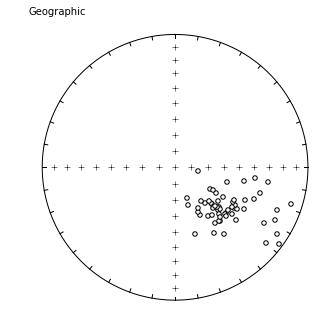

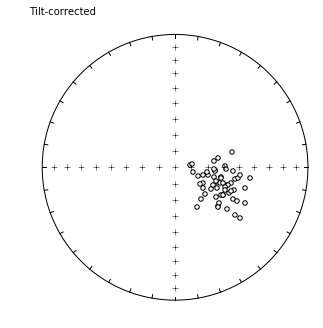


tightest grouping of vectors obtained at (95% confidence bounds):
98 - 119 percent unfolding
range of all bootstrap samples: 
77  -  119 percent unfolding


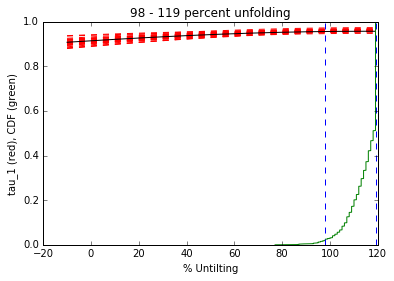

In [17]:
ipmag.bootstrap_fold_test(OslerR_upper_diddd)

## Plotting VGPs

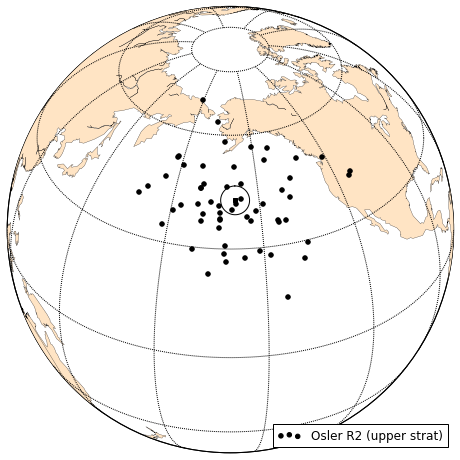

In [18]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='ortho',lat_0=35,lon_0=200,resolution='c',area_thresh=50000)
plt.figure(figsize=(8, 8))
m.drawcoastlines(linewidth=0.25)
m.fillcontinents(color='bisque',lake_color='white',zorder=1)
m.drawmapboundary(fill_color='white')
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))

SH_vgps = ipmag.make_di_block(SH2014_OslerR_upper['vgp_lon_rev'].tolist(),
                              SH2014_OslerR_upper['vgp_lat_rev'].tolist())
Halls_vgps = ipmag.make_di_block(Halls1974_Osler_Data_R['vgp_lon_rev'].tolist(),
                              Halls1974_Osler_Data_R['vgp_lat_rev'].tolist())

pole_mean = pmag.fisher_mean(SH_vgps+Halls_vgps)

ipmag.plot_vgp(m,SH2014_OslerR_upper['vgp_lon_rev'].tolist()+Halls1974_Osler_Data_R['vgp_lon_rev'].tolist(),
               SH2014_OslerR_upper['vgp_lat_rev'].tolist()+Halls1974_Osler_Data_R['vgp_lat_rev'].tolist(),label='Osler R2 (upper strat)')
ipmag.plot_pole(m,pole_mean['dec'],
              pole_mean['inc'],
              pole_mean['alpha95'],
              marker='s')

plt.legend(loc=4)
plt.show()

Results of Watson V test: 

Watson's V:           5.4
Critical value of V:  6.4
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 7.0
Critical angle for M&M1990:   7.6
The McFadden and McElhinny (1990) classification for
this test is: 'B'


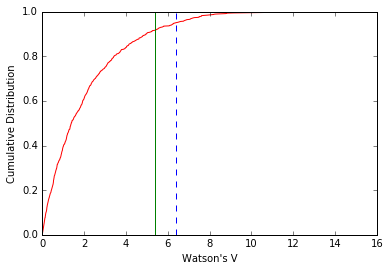

In [19]:
ipmag.watson_common_mean(SH_vgps,Halls_vgps,NumSims=1000,plot='yes')